
===

Data Challenge:

For this data science challenge, you are provided with a dataset containing mobility traces of ~500 taxi cabs in San Francisco collected over ~30 days. The format of each mobility trace file is the following - each line contains [latitude, longitude, occupancy, time], e.g.: [37.75134 -122.39488 0 1213084687], where latitude and longitude are in decimal degrees, occupancy shows if a cab has a fare (1 = occupied, 0 = free) and time is in UNIX epoch format.

The goal of this data science challenge is twofold:

1. To calculate the potential for a yearly reduction in CO2 emissions, caused by the taxi cabs roaming without passengers. In your calculation please assume that the taxicab fleet is changing at the rate of 15% per month (from combustion engine-powered vehicles to electric vehicles). Assume also that the average passenger vehicle emits about 404 grams of CO2 per mile.

2. To build a predictor for taxi drivers, predicting the next place a passenger will hail a cab.

3. (Bonus question) Identify clusters of taxi cabs that you find being relevant from the taxi cab company point of view.

===

Instructions:

Please prepare the presentation with your results. In the final presentation, you'll have to justify and explain:

1. Explanatory data analysis that you performed.

2. All the preprocessing steps that you made. Please be ready to explain any assumptions you made during the preprocessing phase.

3. Modeling techniques that you used to build your predictor

4. The metrics and methods that you used to quantify the performance of your prediction

You'll have 20 min to present (sharp), followed by Q&A session of 30 min, leaving 10 min for wrap-up and next steps.

Together with your presentation, you'll need to provide us with your source code written in Python. The best will be if you could share with us your code via GitHub - please send us an email to [1] Krzysztof.Stec@pmi.com [2] Nidhi.Singh@pmi.com and [3] Michal.Piorkowski@pmi.com when ready.

The Interviewers will be waiting for you in the call at June 17, 2022 (Friday) at 2:00 PM (Central European Summer Time).


## Imports, Global Vars
- we limit the dataset too 100 files. 

In [1]:
# !pip install haversine
# !pip install folium
# !pip install geopy

In [2]:
%run mlhelpers.py
%matplotlib inline
import glob
import re
import haversine as hs 
from haversine import Unit

pd.set_option('display.float_format', lambda x: f'%.{len(str(x%1))-2}f' % x)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)

In [3]:
# folder_path = './data/'
# all_files = glob.glob(os.path.join(folder_path , "*.txt"))
# len(np.unique(all_files))
# all files are unique 

In [158]:
def joinFiles(folder_path = './data/'):
    all_files = glob.glob(os.path.join(folder_path , "*.txt"))
    print(len(all_files))
    all_files = np.random.choice(all_files,100)
    
    li = []

    for filename in all_files:
        df = pd.read_csv(filename,sep=' ', header=None)
        df.index = filename.split('.')[0] + "_" + df.index.map(str)
        df.columns = ['Latitude', 'Longitude', 'Occupancy', 'Timestamp']
        df['Taxi'] = re.split('./', filename)[2].replace('.txt','')
        li.append(df)

    frame = pd.concat(li, axis=0, ignore_index=True)
    return frame

df = joinFiles()

537


In [159]:
df[df.Occupancy==1].head()

,Latitude,Longitude,Occupancy,Timestamp,Taxi
8,37.7805099999999996,-122.3905299999999983,1,1212617873,new_efmymo
9,37.7793599999999969,-122.3904600000000045,1,1212617936,new_efmymo
10,37.7793100000000024,-122.3904500000000013,1,1212617995,new_efmymo
11,37.7789500000000018,-122.3910000000000053,1,1212618053,new_efmymo
12,37.779519999999998,-122.3936000000000064,1,1212618114,new_efmymo


In [160]:
(df.Occupancy.value_counts()/df.shape[0])*100

0    54.8700336540176679
1   45.12996634598233214
Name: Occupancy, dtype: float64

### Outlier Detection

In [161]:
df.Latitude.describe()

count             2102275.0
mean    37.7645763631256486
std     0.05210257156277652
min     34.8095599999999976
25%      37.757159999999999
50%     37.7811999999999983
75%     37.7904399999999967
max     50.3054599999999965
Name: Latitude, dtype: float64

In [53]:
print(df.shape)
print(df[df.Latitude>38].shape)
df = df[df.Latitude<38]

(2166692, 9)
(8, 9)


In [54]:
df.Longitude.describe()

count                2166684.0
mean     -122.4127784351431956
std       0.034753344339070305
min     -125.83004999999999995
25%      -122.4253400000000056
50%      -122.4112200000000001
75%      -122.4005300000000034
max                     -122.0
Name: Longitude, dtype: float64

In [23]:
df.Taxi.nunique() # maybe we miss some names 
# all_files = glob.glob(os.path.join('./data/' , "*.txt"))

87

In [7]:
def calcLag(df):
    df['PrevLat'] = df.Latitude.shift(1)
    df['PrevLong'] = df.Longitude.shift(1)
    df = df.dropna()
    return df

In [8]:
df_lag = df.groupby('Taxi',as_index=False).apply(calcLag).droplevel(0).reset_index().drop(columns='index')

In [9]:
# https://towardsdatascience.com/calculating-distance-between-two-geolocations-in-python-26ad3afe287b
def calcDist(row):
    dist = hs.haversine((row.Latitude,row.Longitude), (row.PrevLat,row.PrevLong)
             ,unit=Unit.MILES)
    return dist

df_lag['DistMiles'] = df_lag.apply(calcDist, axis=1)

In [10]:
df_lag.head()

,Latitude,Longitude,Occupancy,Timestamp,Taxi,PrevLat,PrevLong,DistMiles
0,37.7779099999999985,-122.4383399999999966,1,1211018465,new_abgibo,37.773299999999999,-122.4373999999999967,0.32263102192186754
1,37.7830399999999997,-122.439549999999997,1,1211018525,new_abgibo,37.7779099999999985,-122.4383399999999966,0.3605556976431186
2,37.782980000000002,-122.4426799999999957,1,1211018586,new_abgibo,37.7830399999999997,-122.439549999999997,0.1709703868989221
3,37.7822900000000033,-122.4489700000000028,1,1211018646,new_abgibo,37.782980000000002,-122.4426799999999957,0.346772976358932
4,37.78172,-122.4538900000000012,1,1211018707,new_abgibo,37.7822900000000033,-122.4489700000000028,0.271541591611621


### EDA Report

In [66]:
# # # SweetViz Report
# # my_report = sv.analyze(train)
# # my_report.show_html() 

# # Pandas_Profiling_Report
# profile = ProfileReport(df)
# profile.to_file("Pandas_Profiling_Report.html")


## Q1: CO2 Reduction

In [165]:
# co2 estimation 
df_lag['co2'] = df_lag.DistMiles*404

In [166]:
# No occupancy
co2_taxi = df_lag[df_lag.Occupancy==0].groupby('Taxi')['co2'].sum().reset_index()

In [167]:
k=0.15 # assuming a reduction of 15% per month
final_factor = pow(1-k,12)

In [168]:
co2_taxi['Reduction'] = co2_taxi.co2*final_factor

**Yearly Reduction per taxi**

<AxesSubplot:xlabel='Taxi', ylabel='Reduction'>

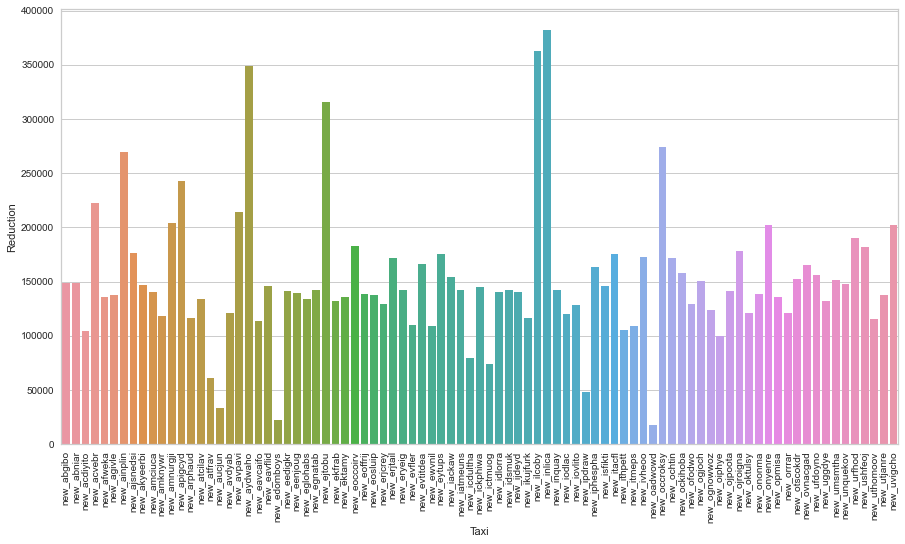

In [15]:
fig,ax = plt.subplots(figsize=[15,8])
# ax.set_xticklabels(rotation=90)
ax.set_xticklabels(co2_taxi.Taxi, rotation = 90)
sns.barplot(data=co2_taxi, x='Taxi', y='Reduction', ax = ax)

# Q2 - predictor for taxi drivers, predicting the next place a passenger will hail a cab.

## Build some time features

In [ ]:
df['Date'] = pd.to_datetime(df_lag.Timestamp,unit='s')
df['DayOfWeek'] = df.Date.apply(lambda x:x.weekday())
df['DayOfMonth'] = df.Date.apply(lambda x:x.day)

In [96]:
df['HourOfDay'] = df.Date.dt.hour
df['MinuteOfHour'] = df.Date.dt.minute

In [92]:
# df.groupby(['Occupancy','HourOfDay'])
# import plotly.express as px
# fig = px.scatter_geo(df,lat='Latitude',lon='Longitude', hover_name="Occupancy")
# fig.update_layout(title = 'Heatmap', title_x=0.5)
# fig.show()

limit_taxis_plot = 30
dft = df[df.Taxi.isin(np.random.choice(df.Taxi,limit_taxis_plot))]
dft = dft[((dft.Latitude>37) &(dft.Latitude<38))]
dft = dft[(dft.Longitude<122.6)]

group_col_plot = 'DayOfWeek'

def show_grouped_plot(group_col_plot='DayOfWeek'):
    fig, ax = plt.subplots(figsize=(10,5))
    for key, grp in dft[dft.Occupancy==1].groupby(group_col_plot):
        ax.scatter(grp['Latitude'], grp['Longitude'], label=key)

    ax.legend()
    plt.show()
    return

# show_grouped_plot(group_col_plot='DayOfWeek')

In [83]:
# show_grouped_plot(group_col_plot='Occupancy')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<AxesSubplot:xlabel='Latitude', ylabel='Longitude'>

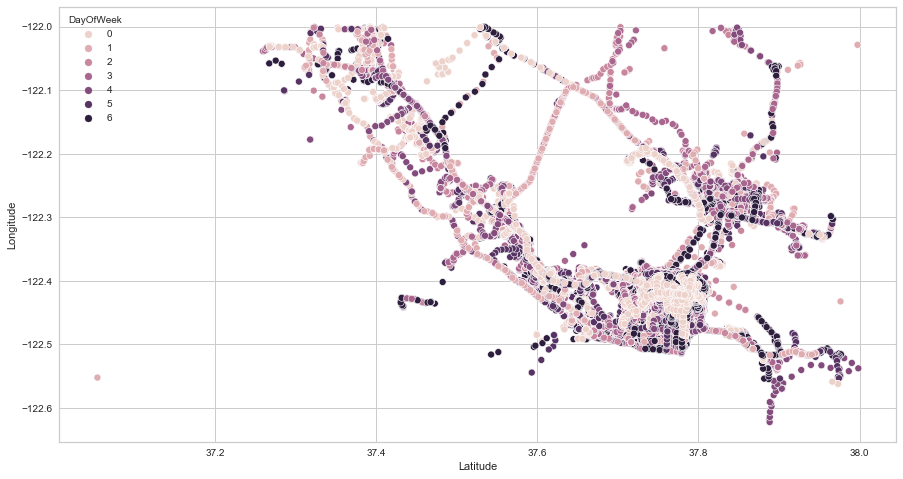

In [84]:
fig,ax = plt.subplots(figsize=[15,8])
ax.legend()
sns.scatterplot(x= dft['Latitude'], y = dft['Longitude'], hue = dft['DayOfWeek'],ax=ax)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<AxesSubplot:xlabel='Latitude', ylabel='Longitude'>

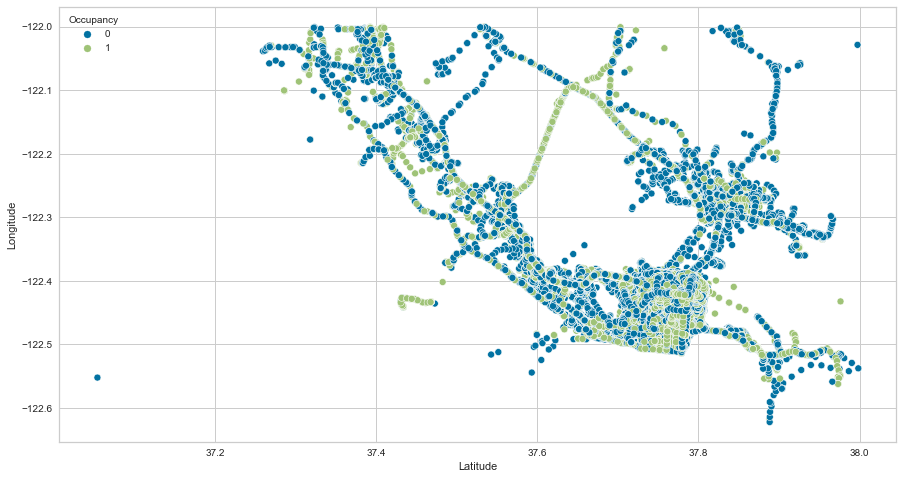

In [85]:
fig,ax = plt.subplots(figsize=[15,8])
ax.legend()
sns.scatterplot(x= dft['Latitude'], y = dft['Longitude'], hue = dft['Occupancy'],ax=ax)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<AxesSubplot:xlabel='Latitude', ylabel='Longitude'>

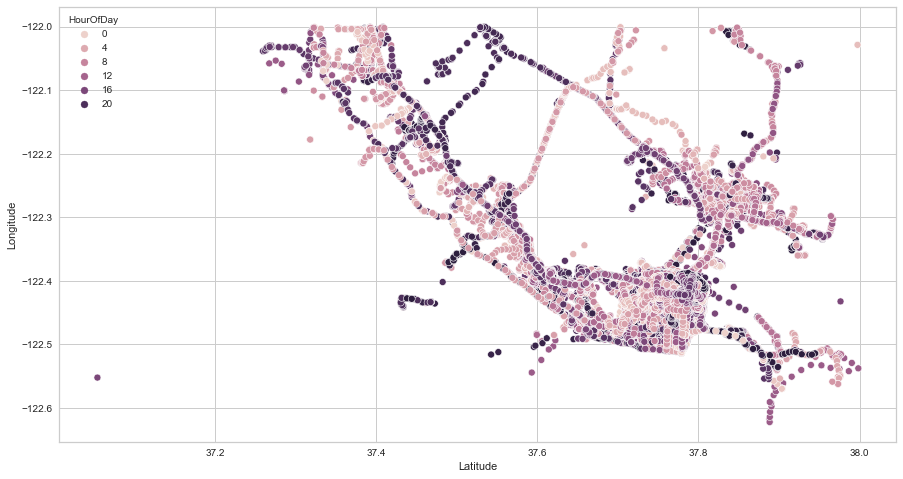

In [86]:
fig,ax = plt.subplots(figsize=[15,8])
ax.legend()
sns.scatterplot(x= dft['Latitude'], y = dft['Longitude'], hue = dft['HourOfDay'],ax=ax)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<AxesSubplot:xlabel='Latitude', ylabel='Longitude'>

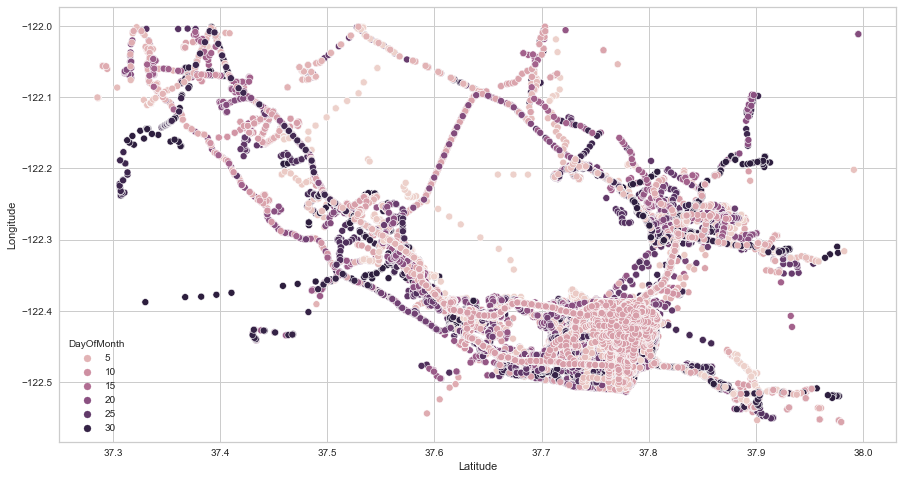

In [93]:
fig,ax = plt.subplots(figsize=[15,8])
ax.legend()
sns.scatterplot(x= dft['Latitude'], y = dft['Longitude'], hue = dft['DayOfMonth'],ax=ax)

### Show how the target varies across the features

In [99]:
show_top_k_pump_cat(df)

,0,1,nr_classes,all_classes,perc_0,perc_1
DayOfWeek,,,,,,
6.0,204409,170342,374751,2166597,54.5,45.5
5.0,186165,155774,341939,2166597,54.3999999999999986,45.6000000000000014
0.0,189630,150608,340238,2166597,55.7000000000000028,44.29999999999999716
4.0,157868,127735,285603,2166597,55.29999999999999716,44.7000000000000028
3.0,153890,122429,276319,2166597,55.7000000000000028,44.29999999999999716
2.0,154680,120855,275535,2166597,56.10000000000000142,43.8999999999999986
1.0,151277,120935,272212,2166597,55.6000000000000014,44.3999999999999986


In [ ]:
# given these predictors make a quick model 

In [122]:
df_train = df[['Latitude', 'Longitude','DayOfWeek', 'HourOfDay', 'DayOfMonth', 
               'MinuteOfHour','Occupancy']]
df_train.head()

,Latitude,Longitude,DayOfWeek,HourOfDay,DayOfMonth,MinuteOfHour,Occupancy
0,37.7643899999999988,-122.4584600000000023,5.0,10.0,17.0,1.0,0
1,37.7652399999999986,-122.4543100000000067,5.0,10.0,17.0,2.0,0
2,37.7657900000000026,-122.450010000000006,5.0,10.0,17.0,3.0,0
3,37.7677600000000027,-122.4503500000000003,5.0,10.0,17.0,4.0,0
4,37.7698200000000028,-122.4487699999999961,5.0,10.0,17.0,5.0,0


In [104]:
# Pandas_Profiling_Report
profile = ProfileReport(df_train)
profile.to_file("Pandas_Profiling_Report_ML_dataset.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [129]:
def generateBaseMap(default_location, default_zoom_start=12):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

<AxesSubplot:xlabel='Date'>

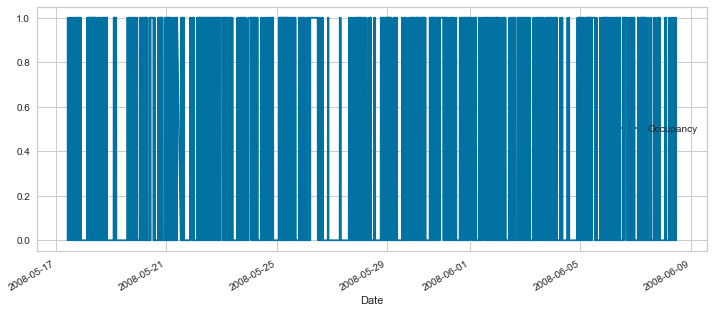

In [146]:
fig,ax = plt.subplots(figsize=[12,5])
df[df.Taxi=='new_oktulsy'].sort_values('Date').plot(x='Date',y='Occupancy',ax=ax)

In [143]:
test_heatmap = df[df.Taxi=='new_oktulsy']

In [135]:
date_list = []
for date in test_heatmap.Date.sort_values().unique():
    date_list.append(test_heatmap.loc[test_heatmap.Date == date, 
                                      ['Latitude', 'Longitude']].values.tolist())

In [147]:
# https://stackoverflow.com/questions/15340537/plotting-time-of-day-and-location-coordinates

In [139]:

base_map = generateBaseMap(default_zoom_start=11,default_location = [test_heatmap.Latitude.iloc[0]
                                                                     , test_heatmap.Longitude.iloc[0]] )
HeatMapWithTime(date_list, radius=5, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}, 
                min_opacity=0.5, max_opacity=0.8, use_local_extrema=True).add_to(base_map)
base_map

## Write dataframe for modelling

In [126]:
df_train.to_csv('./data/df_train.csv',index=None)

## Data checks

In [17]:
# df[df.Taxi.isna()].shape
# 0 